## Generative Models: Generative Antagonistic Networks(GANs)

En este notebook realizaremos una implementación práctica de una red generativa antagónica (GAN), para entender el entrenamiento paralelo de estas dos redes con imágenes de prueba. Utilizaremos la API de Keras-Tensorflow.

Para este ejemplo, utilizaremos el dataset de números de MNIST, que tiene imágenes 28x28 de dígitos del 0-9 en blanco y negro, y entrenaremos una GAN que nos permita generar nuevas imágenes de los mismos.

Este código ha sido adaptado del ejemplo de implementación de DCGAN de Tensorflow: https://www.tensorflow.org/tutorials/generative/dcgan


Tarea:

* ¿Qué resultados tenemos si utilizamos una GAN de Wasserstein?
* Realizar el experimento utilizando otro dataset (e.g. CelebA Dataset: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)

**0. Importar librerías**

In [ ]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Flatten
from keras.optimizers import Adam
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tqdm import tqdm

from IPython import display

In [ ]:
# simplificamos la función de pérdida
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**1. Exploración del dataset**

In [ ]:
# cargamos los datos
(train_images, train_labels), (_, _) = mnist.load_data()

In [ ]:
# tamaño del dataset
print('Train images: ' + str(train_images.shape))
print('Train labels: ' + str(train_labels.shape))

Train images: (60000, 28, 28)
Train labels: (60000,)


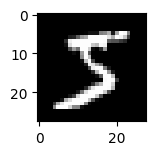

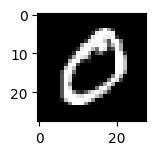

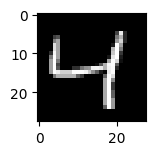

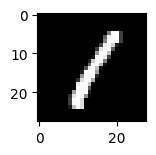

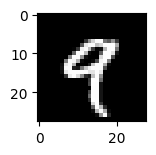

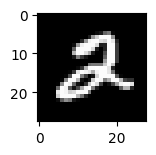

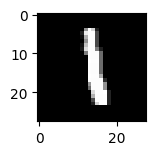

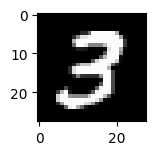

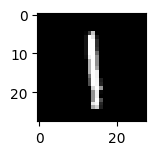

In [ ]:
# visualizacion de imagenes
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
  plt.show()

In [ ]:
# normalizamos imágenes a valores entre -1 y 1
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [ ]:
# shuffle y batching de imágenes
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

**2. Construcción del generador**

Construiremos una red neuronal generadora de imágenes utilizando capas de convolución 2D.

Como vimos anteriormente, las capas Conv2D disminuyen el tamaño de la imagen al realizar la convolución con una matriz kernel de tamaño menor. Las capas Conv2DTranspose realizan lo contrario, aumentando el tamaño de la imagen. Como aquí queremos partir de un vector de ruido pequeño y convertirlo en una imagen, gradualmente aumentamos el tamaño de la imagen con Conv2DTranspose.

In [ ]:
def make_generator_model():
    model = Sequential()

    # 1er bloque
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))

    # 2do bloque
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # 3er bloque
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # capa de salida
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

Definimos la función de pérdida del generador.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Podemos ver que el generador convierte un vector de ruido en una imagen.

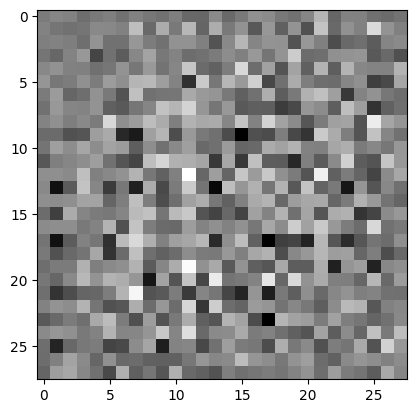

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

**3. Construcción del discriminador**

Construimos ahora una red clasificadora de imágenes, la cual sigue una estructura muy similar a las redes convolucionales 2D que habíamos visto anteriormente.

En este caso realizamos lo contrario, donde tomamos una imagen y la vamos reduciendo con Conv2D hasta obtener un vector latente que podamos clasificar de forma binaria en la última capa.

In [ ]:
def make_discriminator_model():
    model = Sequential()

    # 1er bloque
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    # 2do bloque
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    # capa de salida
    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

Definimos la función de pérdida del discriminador.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Podemos ver un ejemplo de la salida del discriminador para una imagen.

In [ ]:
decision = discriminator(generated_image)
print('Probabilidad resultante: {}'.format(decision.numpy()[0][0]))

Probabilidad resultante: 0.0001571329776197672


**4. Entrenamiento Personalizado**

Debemos definir un optimizador por cada red neuronal. En este caso, utilizamos el mismo

In [ ]:
# definimos los optimizadores de cada red
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [ ]:
# definir parámetros de entrenamiento
no_epoch = 30
noise_dim = 100
num_examples = 16
seed = tf.random.normal([num_examples, noise_dim])

Para realizar el entrenamiento personalizado de las redes, necesitamos poder recuperar los gradientes en cada paso y aplicarlos adecuadamente para obtener las funciones de pérdida que queremos optimizar. Usualmente la API de Keras ya realiza todo este proceso de forma automática, pero cómo necesitamos modificar la propagación hacia atrás utilizamos el método de GradientTape, que nos permite calcular los gradientes intermedios en cada paso del entrenamiento y así tener control sobre cada paso de la propagación hacia atrás.
(https://www.tensorflow.org/api_docs/python/tf/GradientTape).

Para implementarlo, definimos una función de entrenamiento para cada paso, indicando con un 'decorador' que es una función asociada a Tensorflow (para utilizar procesamiento paralelo). Posteriormente, construimos el ciclo de entrenamiento utilizando esta función.

In [ ]:
# definimos el entrenamiento en cada paso
@tf.function
def train_step(images):
    # obtenemos el ruido para el generador
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # obtenemos las imágenes del generador
      generated_images = generator(noise, training=True)

      # obtenemos las etiquetas del discriminador para la imagen real y generada
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      # calculamos las perdidas del generador y discrimininador
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # obtenemos los gradientes del generador y discriminador
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # actualizamos los pesos del generador y discriminador
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
# definimos el bucle de entrenamiento
def train_model(dataset, epochs):
  for epoch in tqdm(range(epochs)):

    # entrenamos para cada bache de imágenes
    for image_batch in dataset:
      train_step(image_batch)

    # guardar imágenes en pasos intermedios
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # cuando se realiza inferencia, el parametro de training se pone en Falso
  # para evitar actualizar los gradientes del modelo
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

**5. Entrenar el modelo**

Entrenamos el modelos utilizando las funciones definidas anteriormente.

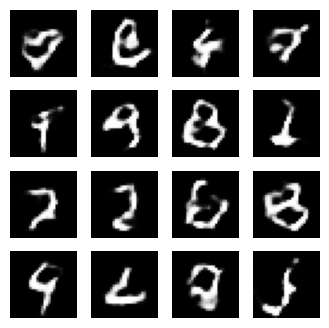

In [ ]:
train_model(train_dataset, no_epoch)

**6. Inferencia**

Podemos también ver algunas de las imágenes generadas durante el entrenamiento.

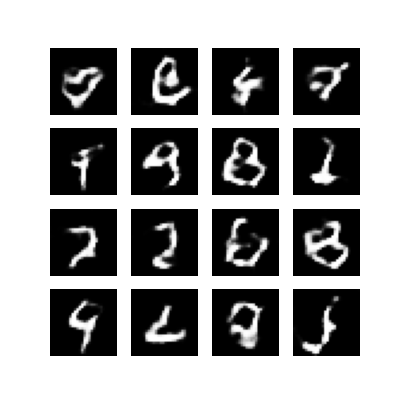

In [ ]:
PIL.Image.open('image_at_epoch_{:04d}.png'.format(30))

Podemos generar nuevas imágenes con la red entrenada.

Predicción del Discriminador: 33.0 %


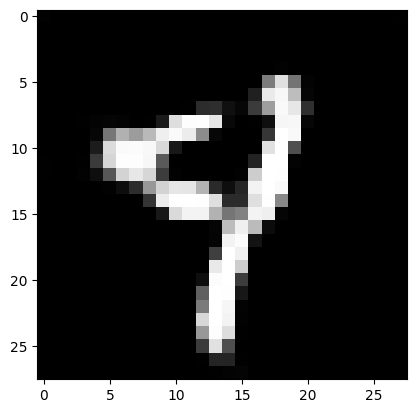

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

discriminator_pred = -round(discriminator(generated_image).numpy()[0][0]*100,2)
print(f'Predicción del Discriminador: {discriminator_pred} %')

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

**7. Guardar modelo**

Podemos guardar el modelo a mitad del entrenamiento utilizar 'checkpoints' de tal manera que podamos reestablecerlo más adelante.

In [ ]:
if os.path.exists!='./training_checkpoints':
  os.mkdir('./training_checkpoints')
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# debemos guardar los optimizadores y los pesos del modelo
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Solo necesitamos modificar el bucle de entrenamiento para agregar el guardado del modelo.

In [ ]:
# definimos el bucle de entrenamiento
def train_model(dataset, epochs):
  for epoch in tqdm(range(epochs)):

    # entrenamos para cada bache de imágenes
    for image_batch in dataset:
      train_step(image_batch)

    # guardar modelo cada 10 epocas
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

Podemos recuperar el modelo utilizando el método de restauración.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

**8. Opcional. Implementación por medio de clases**

Cuando uno quiere tener un mayor control en las funciones de propagación y entrenamiento, es posible utilizar programación orientada a objetos para definir a las redes como clases y a las funciones de propagación como métodos del mismo.

Una implementación similar a la de este ejercicio pero con clases se puede encontrar en la siguiente liga por Aman Krishna: https://medium.com/@mnkrishn/gan-build-using-tensorflow-3d9ca7cef21f

Tarea:

* Implementar la misma red neuronal anterior pero utilizando clases y comparar los resultados obtenidos y tiempo de ejecución.